# Data from Frankefunction

In [27]:
import sys
sys.path.insert(1, '../')

In [28]:
from functions import *
#from main import * 

In [29]:
x,y,z = generate_data()

Defining variables next: 

In [30]:
degrees = np.linspace(1,10,10)

bias = np.zeros(len(degrees))
variance = np.zeros(len(degrees))

test_MSE_OLS = np.zeros(len(degrees))
test_R2 = np.zeros(len(degrees))

train_MSE = np.zeros(len(degrees))
train_R2 = np.zeros(len(degrees))

CI = np.zeros((len(degrees),3))

# Ordinary Least Square

Performing 5 fold cross-validation with our 'OLS'.

In [31]:
k = 5 #cross fold
for polygrad in degrees:

    j = int(polygrad) - 1
    scores, betas_OLS = bias_variance(x,y,z,polygrad,k, regressiontype='OLS')

    train_MSE[j] = scores[0]
    train_R2[j] = scores[1]

    test_MSE_OLS[j] = scores[2]
    bias[j] = scores[3]
    variance[j] = scores[4]
    CI[j] = scores[5]
    
    if (test_MSE_OLS[j]>= (bias[j]+variance[j])):
        print ("Correct: ")
    else :
        print ("MSE is not equal to variance + bias^2 by : {}".format(test_MSE_OLS[j]-(bias[j]+variance[j])))
    print('{} >= {} + {} = {}'.format(test_MSE_OLS[j],bias[j], variance[j], bias[j]+variance[j]))
    print (" ")

Correct: 
0.02873885090662337 >= 0.028689950876167457 + 4.890003045590499e-05 = 0.028738850906623363
 
MSE is not equal to variance + bias^2 by : -3.469446951953614e-18
0.0173087073561398 >= 0.017188489553482185 + 0.00012021780265761989 = 0.017308707356139805
 
MSE is not equal to variance + bias^2 by : -1.734723475976807e-18
0.007595537423348994 >= 0.007550709915077269 + 4.48275082717266e-05 = 0.007595537423348996
 
Correct: 
0.004553923430188495 >= 0.00450157633898175 + 5.234709120674516e-05 = 0.004553923430188495
 
Correct: 
0.002313640661616141 >= 0.002233228406890123 + 8.04122547260176e-05 = 0.002313640661616141
 
MSE is not equal to variance + bias^2 by : -2.168404344971009e-19
0.001787227499714348 >= 0.0017228857848088387 + 6.434171490550949e-05 = 0.0017872274997143482
 
MSE is not equal to variance + bias^2 by : -2.168404344971009e-19
0.0008359511527774152 >= 0.000756149634006592 + 7.98015187708234e-05 = 0.0008359511527774154
 
Correct: 
0.0005987157721621587 >= 0.0005611948105

We can also calculate the confidence interval. 

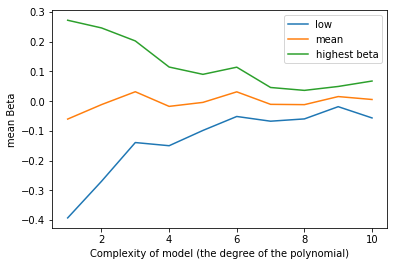

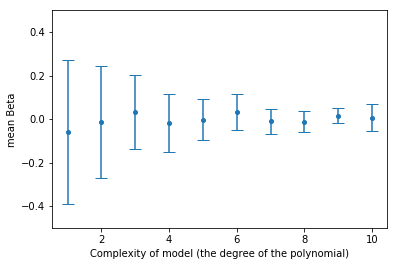

In [32]:
plt.plot(degrees,CI[:,0])
plt.plot(degrees,CI[:,1])
plt.plot(degrees,CI[:,2])
plt.legend(["low","mean", "highest beta"])
plt.ylabel("mean Beta")
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.show()


fig, ax = plt.subplots()

ax.set_ylim(-0.5,0.5)
import seaborn as sns
(_, caps, _) = plt.errorbar(degrees, CI[:,1], yerr=(CI[:,0]-CI[:,1]), fmt='o', markersize=4, capsize=6,label='jepp')

for cap in caps:
    cap.set_markeredgewidth(1)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("mean Beta")
plt.show()


Here we would like to compare our test and train MSE, and also look at our variance and bias trade-off as a function. 

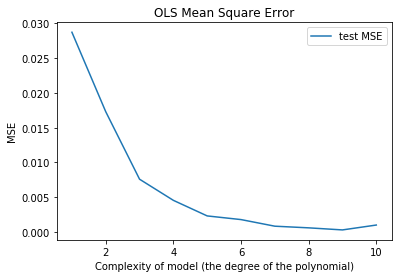

In [33]:
plt.plot(degrees,test_MSE_OLS)
#plt.plot(degrees,train_MSE)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("MSE")
plt.title("OLS Mean Square Error")
plt.legend(["test MSE","train MSE"])
plt.show()

Here we can see that to avoid overfitting we should choose a polynomial degree of 8.

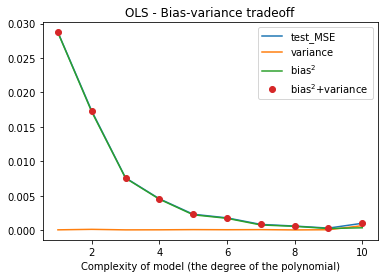

In [34]:
plt.plot(degrees,test_MSE_OLS)
plt.plot(degrees,variance)
plt.plot(degrees,bias)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.title("OLS - Bias-variance tradeoff")
plt.plot(degrees,variance+bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])
plt.savefig('plots/OLS_bias_variance.pdf')
plt.show()

100%|██████████| 10/10 [00:01<00:00,  7.64it/s]


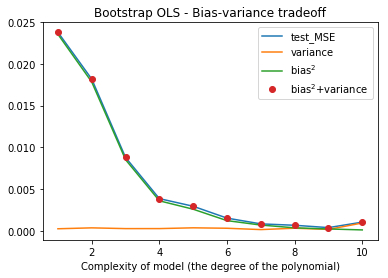

In [35]:
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.2)
import tqdm
#make a design matrix for the test data
mse = np.zeros(len(degrees))
r2 = np.zeros(len(degrees))
bias = np.zeros(len(degrees))
variance = np.zeros(len(degrees))

n_bootstraps = 100
from sklearn.utils import resample
#initialize matrix for storing the predictions
z_pred = np.empty((z_test.shape[0], n_bootstraps))
for degree in tqdm.tqdm(degrees):
    X_test = find_designmatrix(x_test, y_test, polygrad=degree)
    #preforming n_bootstraps sycles
    for i in range(n_bootstraps):
        
        x_, y_, z_ = resample(x_train, y_train, z_train)
        X = find_designmatrix(x_, y_, polygrad=degree)
        beta = OLS(X, z_)
        z_pred_temp = X_test @ beta
        #storing the prediction for evaluation
        z_pred[:, i] = z_pred_temp.ravel()

    z_test = np.reshape(z_test,(len(z_test),1))

    #evaluate predictions
    mse[int(degree)-1] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    r2[int(degree)-1] = np.mean(1 - np.sum((z_test - z_pred)**2, axis=1, keepdims=True)\
                 /np.sum((z_test - np.mean(z_test))**2, axis=1, keepdims=True) )
    bias[int(degree)-1] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[int(degree)-1] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
plt.plot(degrees,mse)
plt.plot(degrees,variance)
plt.plot(degrees,bias)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.title("Bootstrap OLS - Bias-variance tradeoff")
plt.plot(degrees,variance+bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])    
plt.show()

10


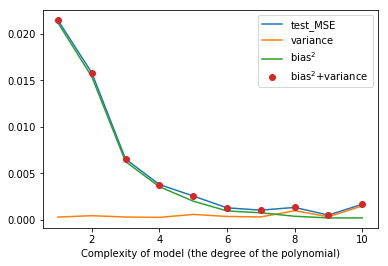

In [36]:
test_bootstrap = bootstrap(x,y,z,degrees,'OLS')

error_bootstrap = test_bootstrap[0]
bias_bootstrap = test_bootstrap[1]
variance_bootstrap = test_bootstrap[2]

plt.plot(degrees,error_bootstrap)
plt.plot(degrees,variance_bootstrap)
plt.plot(degrees,bias_bootstrap)
plt.plot(degrees,variance_bootstrap+bias_bootstrap,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])    
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.show()

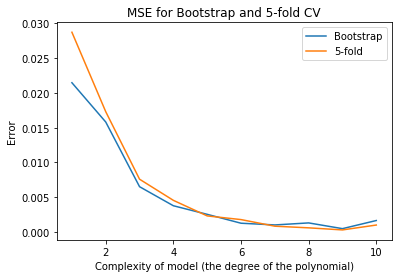

In [37]:
plt.plot(degrees,error_bootstrap)
plt.plot(degrees,test_MSE_OLS)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.title("MSE for Bootstrap and 5-fold CV")
plt.legend(["Bootstrap","5-fold"])
plt.show()

# Ridge regression

We will do much of the same analysis as we did above, but first we need to check which hyperparameter lambda is best. 

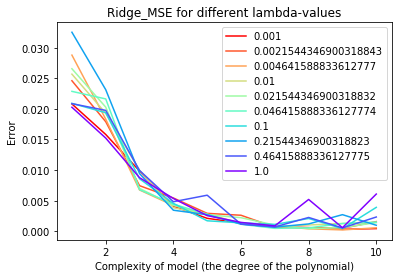

In [38]:
    
nlambdas = 10
lambdas = np.logspace(-3,0,nlambdas)
    
color=iter(cm.rainbow(np.linspace(1,0,nlambdas)))
    
for lamb in lambdas:  
        test2_MSE = Different_Lambdas(x, y, z, degrees, k, lamb, regressiontype='Ridge')       
    
        c = next(color)
        plt.plot(degrees,test2_MSE, c=c)
        plt.legend(lambdas)
        plt.xlabel("Complexity of model (the degree of the polynomial)")
        plt.ylabel("Error")
        plt.title("Ridge_MSE for different lambda-values")
plt.show()

As we can see, the lower the $\lambda$, the better. Thus, we will use $10^{-4}$ as our $\lambda$.

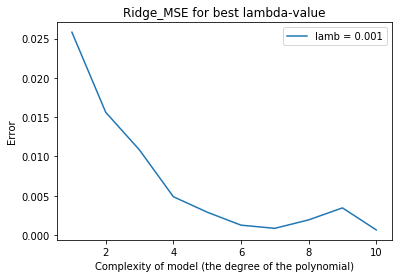

In [39]:
lamb = 1e-3

test_MSE_Ridge, Bias, Variance, beta_Ridge = Best_Lambda(x, y, z, degrees, k, lamb, regressiontype='Ridge')

plt.plot(degrees,test_MSE_Ridge)
plt.legend(["lamb = 0.001"])
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.title("Ridge_MSE for best lambda-value")
plt.show()

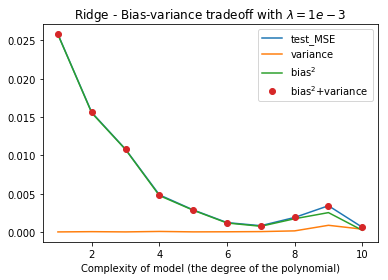

In [40]:
plt.plot(degrees,test_MSE_Ridge)
plt.plot(degrees,Variance)
plt.plot(degrees,Bias)
plt.title("Ridge - Bias-variance tradeoff with $\lambda=1e-3$")
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.plot(degrees,Variance+Bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])
plt.savefig("plots/Ridge_bias_variance.pdf")
plt.show()

# LASSO regression

100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


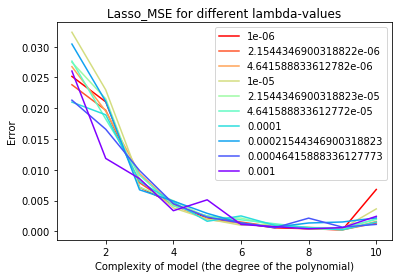

In [41]:
color=iter(cm.rainbow(np.linspace(1,0,nlambdas)))
from tqdm import tqdm
lambdas = np.logspace(-6,-3,nlambdas)
lamb = 0
k = 5

for lamb in tqdm(lambdas):

        test_MSE_LASSO = Different_Lambdas(x, y, z, degrees, k, lamb, regressiontype='Lasso')
        
        c = next(color)
        plt.plot(degrees,test_MSE_LASSO, c=c)
        plt.legend(lambdas)
        plt.xlabel("Complexity of model (the degree of the polynomial)")
        plt.ylabel("Error")
        plt.title("Lasso_MSE for different lambda-values")
plt.show()

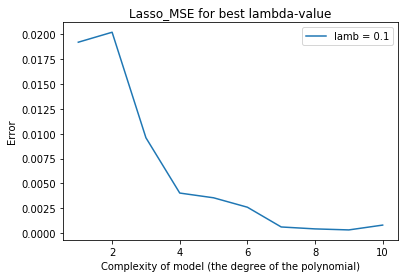

In [42]:
lamb = 0.1

test_MSE_LASSO, Bias, Variance, betas_LASSO = Best_Lambda(x, y, z, degrees, k, lamb, regressiontype='Lasso')

plt.plot(degrees,test_MSE_LASSO)
plt.legend(["lamb = 0.1"])
plt.title("Lasso_MSE for best lambda-value")
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.show()


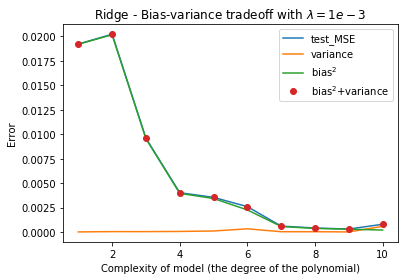

In [43]:
plt.plot(degrees,test_MSE_LASSO)
plt.plot(degrees,Variance)
plt.plot(degrees,Bias)
plt.title("Ridge - Bias-variance tradeoff with $\lambda=1e-3$")
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
plt.plot(degrees,Variance+Bias,'o')
plt.legend(["test_MSE","variance", "bias$^2$","bias$^2$+variance"])
plt.savefig("plots/LASSO_bias_variance.pdf")
plt.show()

# What is the best model?

Now we can try to find out which model is the best. A simple plot of the different regression models with the best $\lambda$ functions will do. 

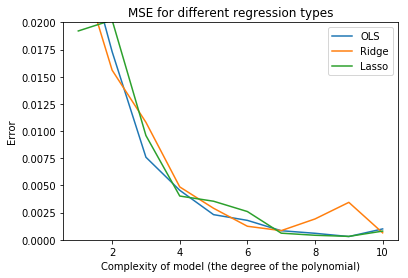

In [44]:
plt.plot(degrees,test_MSE_OLS)
plt.plot(degrees,test_MSE_Ridge)
plt.plot(degrees,test_MSE_LASSO)
plt.xlabel("Complexity of model (the degree of the polynomial)")
plt.ylabel("Error")
axes = plt.gca()

axes.set_ylim([0,0.02])
plt.title("MSE for different regression types")
plt.legend(["OLS","Ridge","Lasso"])
plt.savefig("plots/MSE_all_regressions.pdf")
plt.show()

Here we can see that OLS at polynomial degree 9 has the closest MSE to zero. And we can also find the confidence intervals. 